<class 'pandas.core.frame.DataFrame'>
Index: 2264 entries, 02-01-2015 to 29-12-2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2264 non-null   float64
 1   High    2264 non-null   float64
 2   Low     2264 non-null   float64
 3   Open    2264 non-null   float64
 4   Volume  2264 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.1+ KB
None

Missing values in each column:
 Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


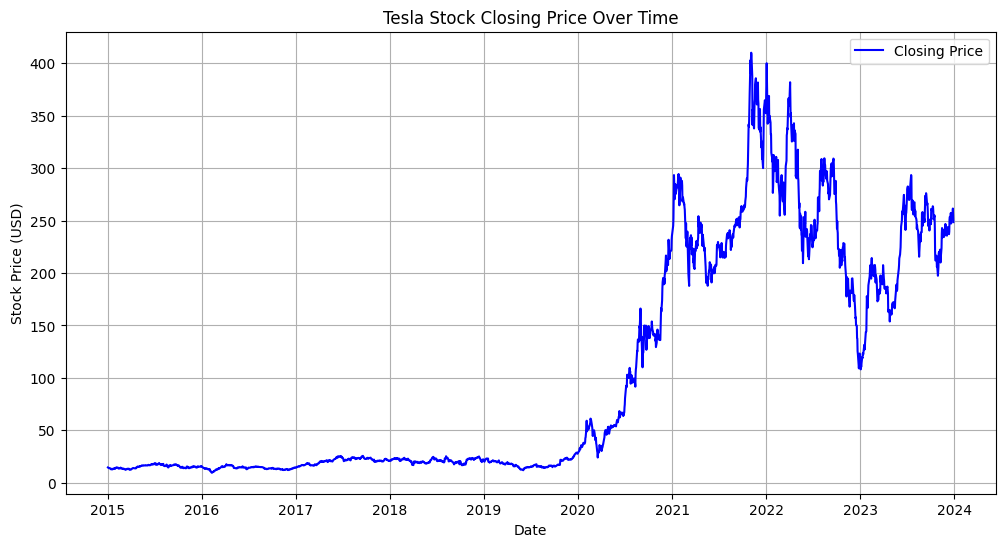

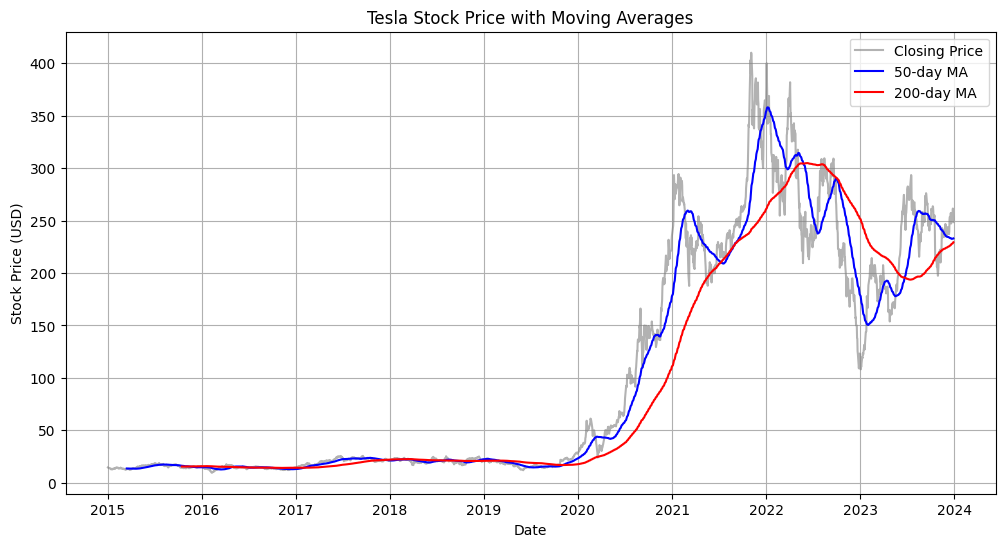

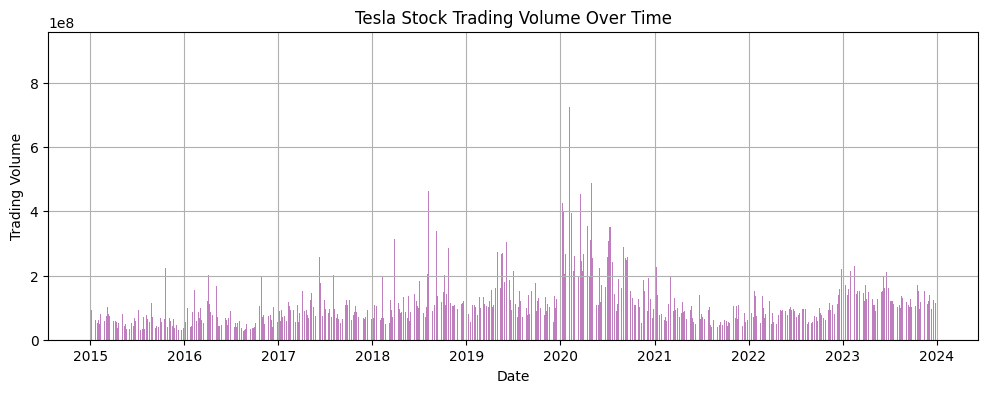

Train data: (1652, 18), Test data: (413, 18)
Data preprocessing complete!
X_train_seq shape: (1592, 60, 1)
X_test_seq shape: (353, 60, 1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the dataset
file_path = "../data/stock_data/TSLA.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Display basic info
print(df.info())
print("\nMissing values in each column:\n", df.isnull().sum())
df.index = pd.to_datetime(df.index, format="%d-%m-%Y")


# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label="Closing Price", color='b')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Tesla Stock Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()

# Create technical indicators
df["MA_50"] = df["Close"].rolling(window=50).mean()
df["MA_200"] = df["Close"].rolling(window=200).mean()

# Plot with moving averages
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", color='gray', alpha=0.6)
plt.plot(df.index, df["MA_50"], label="50-day MA", color='blue')
plt.plot(df.index, df["MA_200"], label="200-day MA", color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Tesla Stock Price with Moving Averages")
plt.legend()
plt.grid()
plt.show()

# Plot volume
plt.figure(figsize=(12, 4))
plt.bar(df.index, df['Volume'], color='purple', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title("Tesla Stock Trading Volume Over Time")
plt.grid()
plt.show()

# Create features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayOfWeek'] = df.index.dayofweek
df['IsMonthStart'] = df.index.is_month_start.astype(int)
df['IsMonthEnd'] = df.index.is_month_end.astype(int)
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()
df['Volatility'] = df['Close'].rolling(window=7).std()
df['Daily_Return'] = df['Close'].pct_change()

# Scale the closing price
close_scaler = MinMaxScaler(feature_range=(0, 1))
df["Close_Scaled"] = close_scaler.fit_transform(df[["Close"]])

# Scale other numerical features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[numeric_cols] = feature_scaler.fit_transform(df[numeric_cols])

# Handle missing values
df.dropna(inplace=True)

# Train-test split (80-20)
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"Train data: {train_data.shape}, Test data: {test_data.shape}")

# Create sequences for LSTM
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

# Prepare sequences
lookback = 60
X_train_seq = np.array(train_data[['Close_Scaled']].values)
X_test_seq = np.array(test_data[['Close_Scaled']].values)

X_train_seq, y_train_seq = create_sequences(X_train_seq, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_seq, lookback)

# Save processed data
joblib.dump(X_train_seq, "../processed_data/X_train_seq.pkl")
joblib.dump(y_train_seq, "../processed_data/y_train_seq.pkl")
joblib.dump(X_test_seq, "../processed_data/X_test_seq.pkl")
joblib.dump(y_test_seq, "../processed_data/y_test_seq.pkl")
joblib.dump(close_scaler, '../processed_data/close_scaler.pkl')

print("Data preprocessing complete!")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")

In [4]:
np.save("../processed_data/TSLA_processed.npy", X_train_seq, allow_pickle=True)
